#### **1. Data Load**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/sample_data/Admission_Predict.csv')

#### **2. Initial Data Analyze**
In this section, we’ll explore the dataset using basic descriptive statistics

In [5]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- Statement of Purpose(SOP) and (LOR)Letter of Recommendation Strength ( out of 5 )
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 ) outcome feature to predict

In [6]:
# The serial number will not be affect the analyze and modeling processes, that's why I updated the dataframe with the neccessary features.
# df_n = df.iloc[:,1:].head()
df = df.drop('Serial No.', axis = 1)

In [7]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [8]:
df.describe().T
# To detect a possible threshold, the summation of the standard deviation and the minimum value can be used.
# GRE Score :

,count,mean,std,min,25%,50%,75%,max
GRE Score,400.0,316.807500,11.473646,290.00,308.00,317.00,325.0000,340.00
TOEFL Score,400.0,107.410000,6.069514,92.00,103.00,107.00,112.0000,120.00
University Rating,400.0,3.087500,1.143728,1.00,2.00,3.00,4.0000,5.00
SOP,400.0,3.400000,1.006869,1.00,2.50,3.50,4.0000,5.00
LOR,400.0,3.452500,0.898478,1.00,3.00,3.50,4.0000,5.00
CGPA,400.0,8.598925,0.596317,6.80,8.17,8.61,9.0625,9.92
Research,400.0,0.547500,0.498362,0.00,0.00,1.00,1.0000,1.00
Chance of Admit,400.0,0.724350,0.142609,0.34,0.64,0.73,0.8300,0.97


#### Checking whether any values are invalid or unexpected

- maximum GRE Score : 340
- minimum GRE Score : 260



- maximum TOEFL Score : 120
- minimum TOEFL Score : 0



- maximum CGPA : 10
- minimum CGPA : 0

#### **3. Value Range Validation**

In [9]:
# upper and lower values check for GRE Score..:

df[(df["GRE Score"] > 340) | (df["GRE Score"] < 260)]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


In [10]:
# upper and lower values check for TOEFL Score..:

df[(df["TOEFL Score"] > 120) | (df["TOEFL Score"] < 0)]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


In [11]:
# upper and lower values check for CGPA..:

df[(df["CGPA"] > 10) | (df["CGPA"] < 0)]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


In [12]:
df[df["TOEFL Score"] > 300]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


In [13]:
# Constant feature check :
print(df.nunique())

# We are checking whether there are any constant-valued features in our DataFrame.
# If a feature has a constant value (e.g., all values are 1), it results in an infinite VIF value due to zero variance.

GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 168
Research               2
Chance of Admit       60
dtype: int64


#### **4. NULL Value Detection**

In [14]:
# Although all features are expected to have no missing values,
# it's still good practice to check for nulls due to potential human error.

df.isnull().sum()

,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


#### **5. Threshold Detection**

In [15]:
def threshold_dedective(col : str, data : pd.DataFrame):
  '''
    Performs outlier detection using the IQR method, and visualizes the distribution
    of the specified column.

    Args:
        col (str): The column name to analyze.
        data (pd.DataFrame): The DataFrame containing the data.

    Prints:
        - Skewness information of the column.
        - Histogram of the column.
        - Calculated lower and upper bounds for potential outliers.
        - Number of data points below and above the threshold.
        - Boxplot showing distribution and outliers.

  '''

  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1

  from scipy.stats import skew, kurtosis

  skewness = round(data[col].skew(),2)
  if skewness == 0:
    print(f"{skewness} : data is symmetric!")
  elif skewness > 0 :
    print(f"{skewness} : data is skeweed to the right!")
  else:
    print(f"{skewness} : data is skeweed to the left!")

  print()

  plt.figure(figsize=(4,3))
  sns.histplot(data[col])
  plt.title(f"Histogram of {col}")
  plt.tight_layout()
  plt.show()


  print()

  lower_bound = Q1 -  IQR * 1.5
  upper_bound =  Q3 + IQR * 1.5
  print(f"lower bound of {col}: {round(lower_bound,2)}")
  print(f"upper bound of {col} : {round(upper_bound,2)}")

  print()

  lowerb = data[data[col] <= lower_bound]
  lowerbShape = lowerb.shape[0]
  upperb = data[data[col] >= upper_bound]
  upperbShape = upperb.shape[0]
  print(f"lower count of {col} : {lowerbShape}")
  print(f"upper count of {col} : {upperbShape}")

  print()

  plt.figure(figsize=(4,3))
  sns.boxplot(data[col])
  plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

-0.06 : data is skeweed to the left!



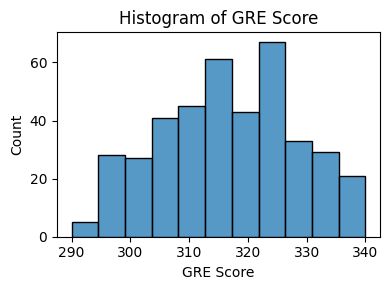


lower bound of GRE Score: 282.5
upper bound of GRE Score : 350.5

lower count of GRE Score : 0
upper count of GRE Score : 0



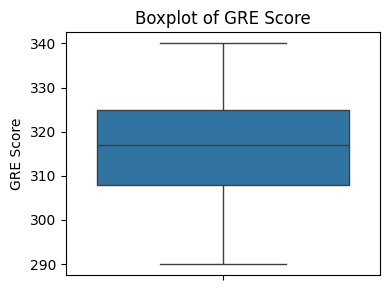

In [16]:
threshold_dedective("GRE Score", df)

0.06 : data is skeweed to the right!



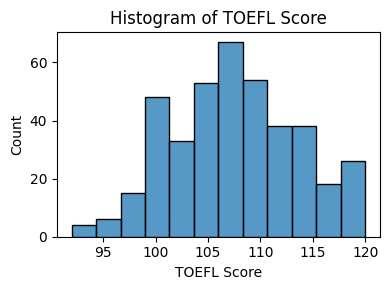


lower bound of TOEFL Score: 89.5
upper bound of TOEFL Score : 125.5

lower count of TOEFL Score : 0
upper count of TOEFL Score : 0



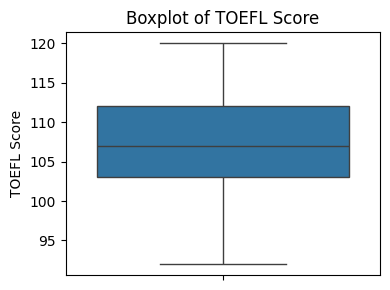

In [17]:
threshold_dedective("TOEFL Score", df)

0.17 : data is skeweed to the right!



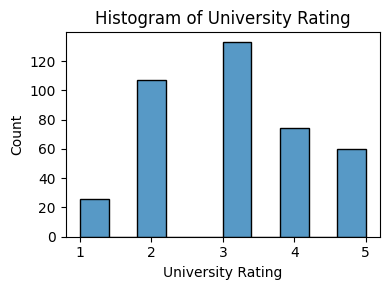


lower bound of University Rating: -1.0
upper bound of University Rating : 7.0

lower count of University Rating : 0
upper count of University Rating : 0



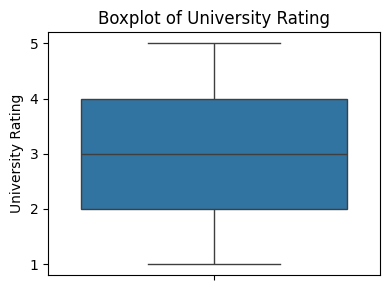

In [18]:
threshold_dedective("University Rating", df)

-0.28 : data is skeweed to the left!



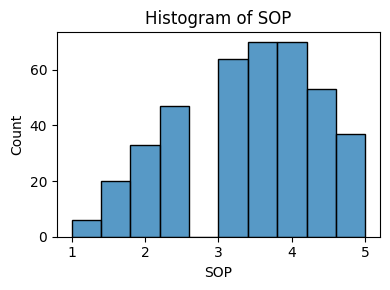


lower bound of SOP: 0.25
upper bound of SOP : 6.25

lower count of SOP : 0
upper count of SOP : 0



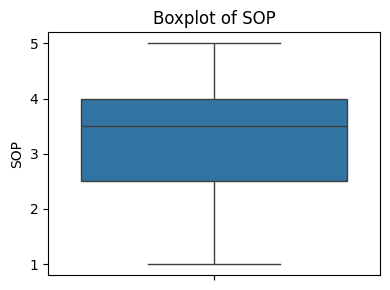

In [19]:
threshold_dedective("SOP", df)

-0.11 : data is skeweed to the left!



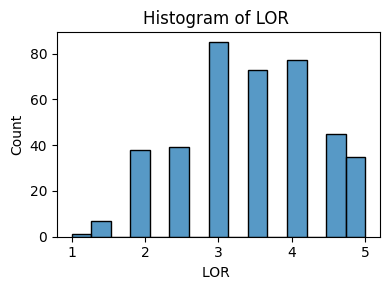


lower bound of LOR : 1.5
upper bound of LOR  : 5.5

lower count of LOR  : 8
upper count of LOR  : 0



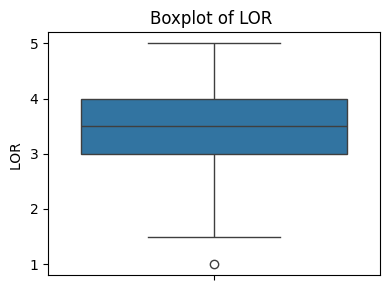

In [20]:
threshold_dedective("LOR ", df)

-0.07 : data is skeweed to the left!



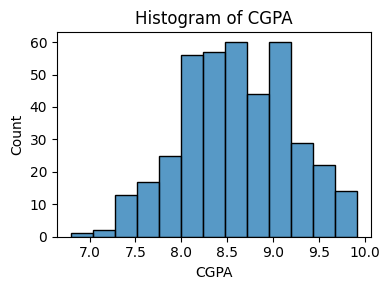


lower bound of CGPA: 6.83
upper bound of CGPA : 10.4

lower count of CGPA : 1
upper count of CGPA : 0



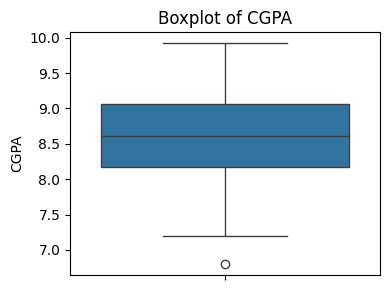

In [21]:
threshold_dedective("CGPA", df)

In [22]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [23]:
# It can be seen that the 'Chance of Admit ' column has a trailing space.
# It would be better to trim this space to standardize all feature names.

df.columns = df.columns.str.strip()

In [24]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [25]:
# to apply different binary values, I added df_a and df_b data frames
df_a = df.copy()
df_b = df.copy()

In [26]:
# Converting the 'Chance of Admit' column into a binary format:
# If the value is greater than or equal to 0.75, assign 1; otherwise, assign 0.

# df_n['Chance of Admit'] = pd.DataFrame([1 if i >= 0.75 else 0 for i in df_n['Chance of Admit' ]])

# A more Pythonic and efficient way to achieve the same result:
df["Chance of Admit Binary"] = (df["Chance of Admit"] >= 0.75).astype(int)
df_a["Chance of Admit Binary"] = (df_a["Chance of Admit"] >= 0.80).astype(int)
df_b["Chance of Admit Binary"] = (df_b["Chance of Admit"] >= 0.70).astype(int)

In [27]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Chance of Admit Binary
0,337,118,4,4.5,4.5,9.65,1,0.92,1
1,324,107,4,4.0,4.5,8.87,1,0.76,1
2,316,104,3,3.0,3.5,8.00,1,0.72,0
3,322,110,3,3.5,2.5,8.67,1,0.80,1
4,314,103,2,2.0,3.0,8.21,0,0.65,0


In [28]:
df["Chance of Admit Binary"].value_counts()

,count
Chance of Admit Binary,
0,220
1,180


In [29]:
df_a["Chance of Admit Binary"].value_counts()

,count
Chance of Admit Binary,
0,272
1,128


In [30]:
df_b["Chance of Admit Binary"].value_counts()

,count
Chance of Admit Binary,
1,247
0,153


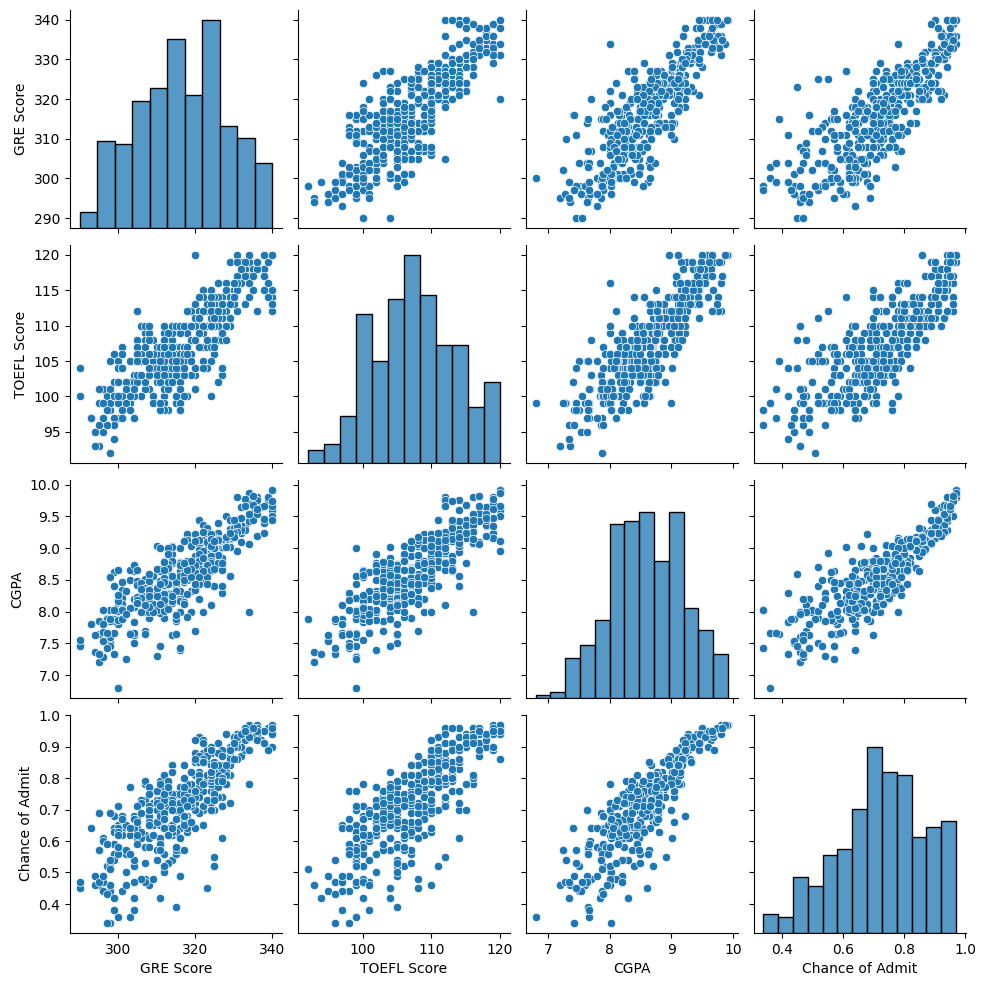

In [31]:
sns.pairplot(df[['GRE Score', 'TOEFL Score', 'CGPA', 'Chance of Admit']])

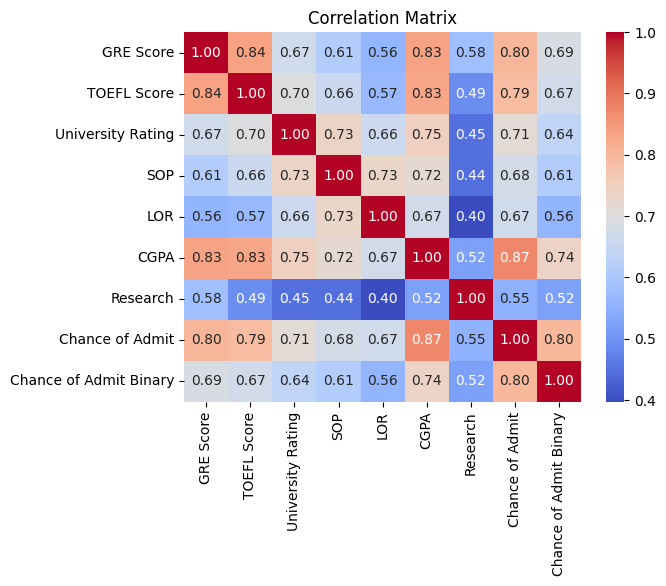

In [32]:
# The correlation between the dependent variable and the independent variables can be determined to identify the most appropriate features.plt.figure(figsize=(10, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We observed high correlated feature such as;
- **TOEFL Score** and **GRE Score** : **0.84** strong positive correlation.
- **CGPA** and **GRE Score** : **0.83**  strong positive correlation.
- **CGPA** and **TOEFL Score** : **0.83**  strong positive correlation.


These strong correlations suggest that multicollinearity may be present among some of the features.

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Create a dataset consists of numberic data.
### And Drop target values
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=["Chance of Admit","Chance of Admit Binary"], errors='ignore')
y = df["Chance of Admit Binary"]
# add intercept
X = add_constant(X)

# Calculate VIF Values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


             Feature          VIF
0              const  1529.672661
1          GRE Score     4.615516
2        TOEFL Score     4.288959
3  University Rating     2.919606
4                SOP     3.075504
5                LOR     2.431258
6               CGPA     5.207403
7           Research     1.543312


In [34]:
X.head()

,const,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1.0,337,118,4,4.5,4.5,9.65,1
1,1.0,324,107,4,4.0,4.5,8.87,1
2,1.0,316,104,3,3.0,3.5,8.00,1
3,1.0,322,110,3,3.5,2.5,8.67,1
4,1.0,314,103,2,2.0,3.0,8.21,0


VIF values for all features are below the threshold of 10, indicating no significant multicollinearity problem. Therefore, standard logistic regression is appropriate for this dataset and there is no strict need for regularization methods such as Ridge or Lasso.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Split the test and train data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We should standardzie the data (so important for the Lojistik Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
# Apply the Logistic Regression Model
model = LogisticRegression(max_iter=1000, solver="liblinear")

# Fit the train data
model.fit(X_train_scaled, y_train)

# Predict the test data
y_pred = model.predict(X_test_scaled)

Model Accuracy Rate: 0.9125

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        47
           1       0.86      0.94      0.90        33

    accuracy                           0.91        80
   macro avg       0.91      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80



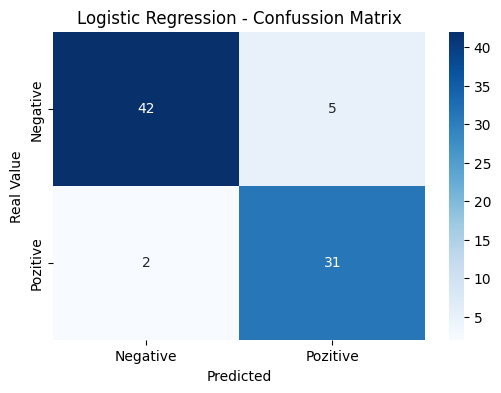

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate the accuracy score of the model :
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Rate: {accuracy:.4f}")

# Classification Report:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusson Matrix :
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualization of the Confussion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Pozitive"], yticklabels=["Negative", "Pozitive"])
plt.xlabel("Predicted")
plt.ylabel("Real Value")
plt.title("Logistic Regression - Confussion Matrix")
plt.show()


In [38]:
from sklearn.linear_model import SGDClassifier
import numpy as np

#Applying the SGDClassifier (Stochastic Gradient Descent) model
sgd_model = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-4, random_state=42, verbose=1)

# Fit the model with the traine data :
sgd_model.fit(X_train_scaled, y_train.values.ravel())

# Showing the coefficients (weights) and the intercept (bias) of the fitted model
print(f"\nLast Bias (b): {sgd_model.intercept_}")
print(f"Last Weights (W): {sgd_model.coef_}")

-- Epoch 1
Norm: 37.88, NNZs: 7, Bias: -9.922999, T: 320, Avg. loss: 3.826109
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 24.18, NNZs: 7, Bias: 3.722604, T: 640, Avg. loss: 2.875460
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 25.39, NNZs: 7, Bias: -5.767029, T: 960, Avg. loss: 2.197752
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 24.45, NNZs: 7, Bias: -1.303528, T: 1280, Avg. loss: 1.842952
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 18.74, NNZs: 7, Bias: -1.301470, T: 1600, Avg. loss: 1.828403
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 13.22, NNZs: 7, Bias: -2.510519, T: 1920, Avg. loss: 1.534981
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 10.24, NNZs: 7, Bias: 0.676767, T: 2240, Avg. loss: 1.495193
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 10.01, NNZs: 7, Bias: -8.804867, T: 2560, Avg. loss: 1.032687
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 9.09, NNZs: 7, Bias: -0.629634, T: 2880, Avg. loss: 1.126072
Total training 

             Feature  Importance
6               CGPA    1.760425
1          GRE Score    0.712291
4                SOP    0.421185
7           Research    0.411757
2        TOEFL Score    0.350921
3  University Rating    0.312069
5                LOR    0.254037
0              const    0.000000



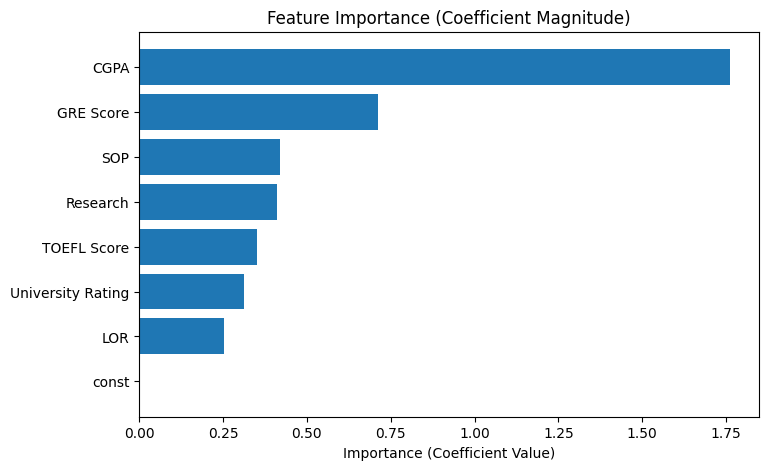

In [39]:
# To see the importances of the features:
importances = model.coef_[0]
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", key=abs, ascending=False)
print(importance_df)
print()

plt.figure(figsize=(8,5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance (Coefficient Value)")
plt.title("Feature Importance (Coefficient Magnitude)")
plt.gca().invert_yaxis()
plt.show()

#### Apllying model with the value of 0.80

In [40]:
# witthe value of 0.80
# Create a dataset consists of numberic data.
### And Drop target values
X_80 = df_a.select_dtypes(include=['float64', 'int64']).drop(columns=["Chance of Admit","Chance of Admit Binary"], errors='ignore')
y_80 = df_a["Chance of Admit Binary"]
# add intercept
X_80 = add_constant(X_80)

In [41]:
# Split the test and train data.
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X_80, y_80, test_size=0.2, random_state=42)

# We should standardzie the data (so important for the Lojistik Regression)
scaler = StandardScaler()
X_train_scaled_80 = scaler.fit_transform(X_train_80)
X_test_scaled_80 = scaler.transform(X_test_80)


In [42]:
# Apply the Logistic Regression Model
model = LogisticRegression(max_iter=1000, solver="liblinear")

# Fit the train data
model.fit(X_train_scaled_80, y_train_80)

# Predict the test data
y_pred_80 = model.predict(X_test_scaled_80)

Model Accuracy Rate: 0.9750

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        51
           1       0.94      1.00      0.97        29

    accuracy                           0.97        80
   macro avg       0.97      0.98      0.97        80
weighted avg       0.98      0.97      0.98        80



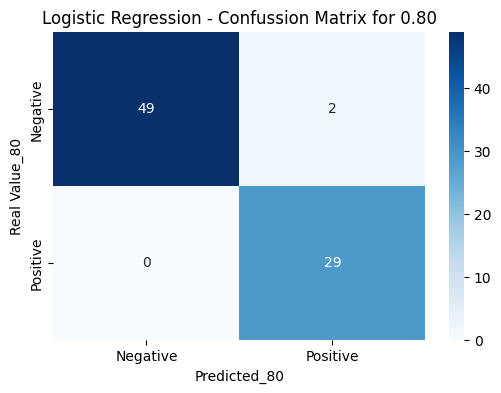

In [43]:
# Calculate the accuracy score of the model :
accuracy = accuracy_score(y_test_80, y_pred_80)
print(f"Model Accuracy Rate: {accuracy:.4f}")

# Classification Report:
print("\nClassification Report:")
print(classification_report(y_test_80, y_pred_80))

# Confusson Matrix :
conf_matrix = confusion_matrix(y_test_80, y_pred_80)

# Visualization of the Confussion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted_80")
plt.ylabel("Real Value_80")
plt.title("Logistic Regression - Confussion Matrix for 0.80")
plt.show()


In [44]:
#Applying the SGDClassifier (Stochastic Gradient Descent) model
sgd_model_80 = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-4, random_state=42, verbose=1)

# Fit the model with the traine data :
sgd_model_80.fit(X_train_scaled_80, y_train_80.values.ravel())

# Showing the coefficients (weights) and the intercept (bias) of the fitted model
print(f"\nLast Bias (b): {sgd_model_80.intercept_}")
print(f"Last Weights (W): {sgd_model_80.coef_}")

-- Epoch 1
Norm: 40.84, NNZs: 7, Bias: -35.963079, T: 320, Avg. loss: 2.993249
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 43.73, NNZs: 7, Bias: -20.532778, T: 640, Avg. loss: 2.276232
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 36.86, NNZs: 7, Bias: -22.294945, T: 960, Avg. loss: 1.683111
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 30.97, NNZs: 7, Bias: -27.559905, T: 1280, Avg. loss: 1.377582
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 25.22, NNZs: 7, Bias: -22.073423, T: 1600, Avg. loss: 1.450935
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 26.50, NNZs: 7, Bias: -11.703390, T: 1920, Avg. loss: 1.125224
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 19.80, NNZs: 7, Bias: -18.551128, T: 2240, Avg. loss: 1.200250
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 17.63, NNZs: 7, Bias: -17.391937, T: 2560, Avg. loss: 0.921595
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 13.25, NNZs: 7, Bias: -15.496589, T: 2880, Avg. loss: 0.961208
Tot

             Feature  Importance
6               CGPA    2.088813
2        TOEFL Score    0.984235
7           Research    0.586483
1          GRE Score    0.532178
3  University Rating    0.441977
5                LOR    0.109205
4                SOP    0.042506
0              const    0.000000



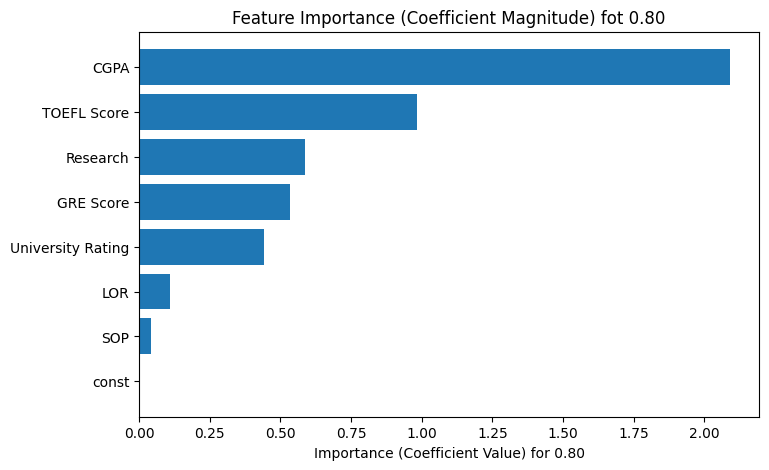

In [45]:
# To see the importances of the features:
importances_80 = model.coef_[0]
importance_df_80 = pd.DataFrame({"Feature": X_train_80.columns, "Importance": importances_80})
importance_df_80 = importance_df_80.sort_values(by="Importance", key=abs, ascending=False)
print(importance_df_80)
print()

plt.figure(figsize=(8,5))
plt.barh(importance_df_80["Feature"], importance_df_80["Importance"])
plt.xlabel("Importance (Coefficient Value) for 0.80")
plt.title("Feature Importance (Coefficient Magnitude) fot 0.80")
plt.gca().invert_yaxis()
plt.show()

#### apllying model with the value of 0.75

In [46]:
# witthe value of 0.80
# Create a dataset consists of numberic data.
### And Drop target values
X_70 = df_b.select_dtypes(include=['float64', 'int64']).drop(columns=["Chance of Admit","Chance of Admit Binary"], errors='ignore')
y_70 = df_b["Chance of Admit Binary"]
# add intercept
X_70 = add_constant(X_70)

In [47]:
# Split the test and train data.
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X_70, y_70, test_size=0.2, random_state=42)

# We should standardzie the data (so important for the Lojistik Regression)
scaler = StandardScaler()
X_train_scaled_70 = scaler.fit_transform(X_train_70)
X_test_scaled_70 = scaler.transform(X_test_70)


In [48]:
# Apply the Logistic Regression Model
model = LogisticRegression(max_iter=1000, solver="liblinear")

# Fit the train data
model.fit(X_train_scaled_70, y_train_70)

# Predict the test data
y_pred_70 = model.predict(X_test_scaled_70)

Model Accuracy Rate: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.91      0.90      0.91        48

    accuracy                           0.89        80
   macro avg       0.88      0.89      0.88        80
weighted avg       0.89      0.89      0.89        80



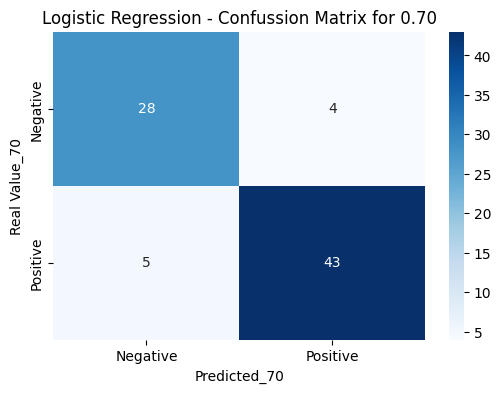

In [49]:
# Calculate the accuracy score of the model :
accuracy = accuracy_score(y_test_70, y_pred_70)
print(f"Model Accuracy Rate: {accuracy:.4f}")

# Classification Report:
print("\nClassification Report:")
print(classification_report(y_test_70, y_pred_70))

# Confusson Matrix :
conf_matrix = confusion_matrix(y_test_70, y_pred_70)

# Visualization of the Confussion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted_70")
plt.ylabel("Real Value_70")
plt.title("Logistic Regression - Confussion Matrix for 0.70")
plt.show()

In [50]:
#Applying the SGDClassifier (Stochastic Gradient Descent) model
sgd_model_70 = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-4, random_state=42, verbose=1)

# Fit the model with the traine data :
sgd_model_70.fit(X_train_scaled_70, y_train_70.values.ravel())

# Showing the coefficients (weights) and the intercept (bias) of the fitted model
print(f"\nLast Bias (b): {sgd_model_70.intercept_}")
print(f"Last Weights (W): {sgd_model_70.coef_}")

-- Epoch 1
Norm: 40.22, NNZs: 7, Bias: 8.365294, T: 320, Avg. loss: 5.099833
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 26.18, NNZs: 7, Bias: 17.703319, T: 640, Avg. loss: 3.667845
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 21.88, NNZs: 7, Bias: 11.824166, T: 960, Avg. loss: 2.932890
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 13.74, NNZs: 7, Bias: 7.300129, T: 1280, Avg. loss: 2.686396
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 19.19, NNZs: 7, Bias: 5.910639, T: 1600, Avg. loss: 2.328407
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 12.18, NNZs: 7, Bias: 9.741897, T: 1920, Avg. loss: 2.162376
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 14.67, NNZs: 7, Bias: 9.439027, T: 2240, Avg. loss: 1.688292
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 11.18, NNZs: 7, Bias: -3.157139, T: 2560, Avg. loss: 1.711981
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 10.53, NNZs: 7, Bias: 7.281378, T: 2880, Avg. loss: 1.407474
Total training tim

             Feature  Importance
6               CGPA    2.088813
2        TOEFL Score    0.984235
7           Research    0.586483
1          GRE Score    0.532178
3  University Rating    0.441977
5                LOR    0.109205
4                SOP    0.042506
0              const    0.000000



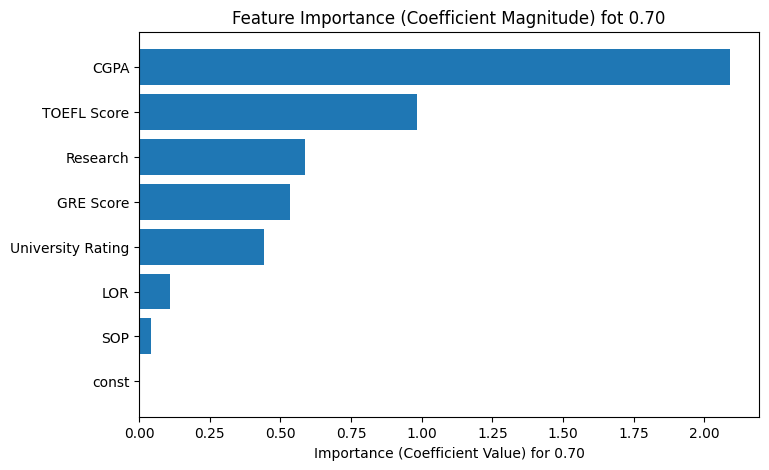

In [51]:
# To see the importances of the features:
importances_70 = model.coef_[0]
importance_df_70 = pd.DataFrame({"Feature": X_train_70.columns, "Importance": importances_80})
importance_df_70 = importance_df_70.sort_values(by="Importance", key=abs, ascending=False)
print(importance_df_70)
print()

plt.figure(figsize=(8,5))
plt.barh(importance_df_70["Feature"], importance_df_70["Importance"])
plt.xlabel("Importance (Coefficient Value) for 0.70")
plt.title("Feature Importance (Coefficient Magnitude) fot 0.70")
plt.gca().invert_yaxis()
plt.show()

#### Result and Command

- As a result, the most effective solution appears to be using a binary classification model with a threshold of greater than or equal to 0.80.

- Additionally, it might be beneficial to aggregate the SOP and LOR scores to potentially achieve better results.